# Graph8 🤵-In-The-Loop with interrupt and Command classes  
- Approval

In [6]:
from typing import TypedDict, Annotated, List
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END, add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode



In [7]:
load_dotenv()
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
# llm = ChatGroq(model="llama-3.1-8b-instant")
memory = MemorySaver()
class State(TypedDict):
    messages: Annotated[List, add_messages]

# tav_key = os.environ["TAVILY_API_KEY"]


search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm_with_tools = llm.bind_tools(tools=tools)

In [8]:
def model(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

def router(state:State):
    last_message = state["messages"][-1]

    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tools"
    else: 
        return "end"

In [9]:
tool_node = ToolNode(tools=tools)

graph = StateGraph(State)
graph.add_node("model", model)
graph.add_node("tools", tool_node)

graph.set_entry_point("model")
graph.add_conditional_edges("model", router, {"tools":"tools", "end":END})
graph.add_edge("tools", "model")

app = graph.compile(checkpointer=memory, interrupt_before=["tools"])

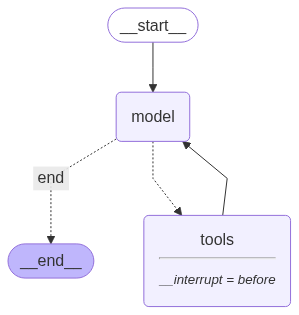

In [10]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [17]:
config = {"configurable":{"thread_id": 1}}
# app.stream is a generator, generates response after every input or node process
# app.invoke returns the entirety of the graph after the graph ends in any way possible. 
results = app.stream({"messages": [HumanMessage(content="What is tomorrow's weather/Temperature in Vaasa, Finland?")]}, config, stream_mode="values")

for action in results:
    action["messages"][-1].pretty_print()

================================ Human Message =================================

What is tomorrow's weather/Temperature in Vaasa, Finland?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (b24e87b2-06c3-4e40-ad1e-2f4e038d52be)
 Call ID: b24e87b2-06c3-4e40-ad1e-2f4e038d52be
  Args:
    query: tomorrow's weather in Vaasa, Finland


In [15]:
currentGraphState = app.get_state(config)
currentGraphState.next

('tools',)

In [18]:
activities = app.stream(None, config, stream_mode="values")
for activity in activities:
    activity["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (b24e87b2-06c3-4e40-ad1e-2f4e038d52be)
 Call ID: b24e87b2-06c3-4e40-ad1e-2f4e038d52be
  Args:
    query: tomorrow's weather in Vaasa, Finland
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Vaasa weather in June 2025 - Weather25.com", "url": "https://www.weather25.com/europe/finland/western-finland/vaasa?page=month&month=June", "content": "| Month | Temperatures | Rainy Days | Dry Days | Snowy Days | Rainfall | Weather | More details |\n| --- | --- | --- | --- | --- | --- | --- | --- |\n| January | **-3°** / -6° | 5 | 7 | 20 | 67 mm | Awful | [Vaasa in January](https://www.weather25.com/europe/finland/western-finland/vaasa?page=month&month=January) |\n| February | **-3°** / -7° | 5 | 5 | 19 | 62 mm | Awful | [Vaasa in February](https://www.weather25.com/europe/finland/western-finland/vaas